In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML
from pqdict import pqdict
import time
import os
from config import get_project_root
import sys


sys.path.append(os.path.dirname(os.path.abspath('config.py')))

start_time = time.time()

# Define the path to the Excel file

project_root = get_project_root()
dataset_path = os.path.join(project_root,  'Dataset', 'Customer demand data with time window in KWH.xlsx')
Distance_path= os.path.join(project_root,  'Dataset', 'Distance matrix between the nodes.xlsx')

distance_matrix = pd.read_excel(Distance_path)
customer_data = pd.read_excel(dataset_path)    
customers_data = customer_data.to_dict(orient='records')

#Input data
vehicles = [{'id': 1, 'type': 'Small', 'capacity': 200, 'speed': 60, 'fuel_cost_per_km': 10, 'hourly_wage': 300},
            {'id': 2, 'type': 'Small', 'capacity': 200, 'speed': 60, 'fuel_cost_per_km': 10, 'hourly_wage': 300},
            {'id': 3, 'type': 'Medium', 'capacity': 250, 'speed': 50, 'fuel_cost_per_km': 12,'hourly_wage': 350},
            {'id': 4, 'type': 'Medium', 'capacity': 350, 'speed': 55, 'fuel_cost_per_km': 12,'hourly_wage': 350},
            {'id': 5, 'type': 'large', 'capacity': 500, 'speed': 45, 'fuel_cost_per_km': 14, 'hourly_wage': 400},
            {'id': 6, 'type': 'large', 'capacity': 500, 'speed': 45, 'fuel_cost_per_km': 14, 'hourly_wage': 400}]

max_radius = 80  # Define max radius for clustering
depot_location= 0
current_time= 8.0
vehicle = vehicles[0] 

def generate_data(num_nodes,  distance_matrix):

    if isinstance(distance_matrix, pd.DataFrame):
        distance_matrix = distance_matrix.to_numpy()

    # Initialize locations array

    locations = np.zeros((num_nodes, 2))
    
    # Set the first node at an arbitrary location (e.g., center of a 100x100 grid)
    locations[0] = [50, 50]
    
    # Place other nodes based on distances from the first node
    for i in range(1, num_nodes):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = distance_matrix[0, i]  # Using direct indexing since distance_matrix is an ndarray
        locations[i] = locations[0] + distance * np.array([np.cos(angle), np.sin(angle)])
    

    nodes = [{
    'id': i,
    'location': locations[i],
    'demand_kWh': (customer['Requirement of KWH'] - customer['Present KWH']),
    'Return_kWh': ((customer['Present KWH']/50-customer['Present KWH']//50)*50),
    'soc': customer['Present SOC'],
    'time_window': (customer['StartTime'], customer['EndTime']),
    'demand_met': False
    } for i, customer in enumerate(customers_data)]
    
    
    return nodes, distance_matrix

In [2]:
def cluster_nodes_by_distance_from_depot(distance_matrix, max_radius):
    # Extract distances from the depot to each node
    depot_distances = distance_matrix[0, 1:]  # Skip the distance to itself (depot)

    # clusters based on distance
    clusters = {}
    for i, distance in enumerate(depot_distances):
        cluster_key = int(distance // max_radius)
        if cluster_key not in clusters:
            clusters[cluster_key] = []
        clusters[cluster_key].append(i + 1)  # (excluding depot)

    # Print clusters
    #print("Clusters formed without including depot:", clusters)
    for key, value in clusters.items():
        print(f"Cluster {key}: Nodes {value}")

    return clusters


In [3]:
def assign_vehicles_to_clusters(clusters, vehicles, nodes, distance_matrix):
    sorted_vehicles = sorted(vehicles, key=lambda v: v['capacity'], reverse=False)
    vehicle_assignments = {v['id']: [] for v in sorted_vehicles}
    vehicle_capacities = {v['id']: v['capacity'] for v in sorted_vehicles}
    vehicle_time_remaining = {v['id']: 8.0 for v in sorted_vehicles}  # Initialize start times
    unassigned_nodes = []

    for cluster_id, node_ids in clusters.items():
        total_demand = sum(nodes[node_id]['demand_kWh'] for node_id in node_ids)
        print(f"Attempting to assign Cluster {cluster_id} with total demand: {total_demand}")

        for node_id in node_ids:
            node_demand = nodes[node_id]['demand_kWh']
            node_time_window = nodes[node_id]['time_window']
            assigned = False

            for vehicle in sorted_vehicles:
                vehicle_id = vehicle['id']
                vehicle_speed = vehicle['speed']
                starting_point = vehicle_assignments[vehicle_id][-1][1] if vehicle_assignments[vehicle_id] else 0

                capacity = vehicle_capacities[vehicle_id]
                travel_time = distance_matrix[starting_point][node_id] / vehicle_speed
                estimated_arrival_time = vehicle_time_remaining[vehicle_id] + travel_time

                # Check if the vehicle can deliver within the time window and has enough capacity
                if node_time_window[0] <= estimated_arrival_time <= node_time_window[1] and node_demand <= capacity:
                    vehicle_assignments[vehicle_id].append((cluster_id, node_id))
                    vehicle_capacities[vehicle_id] -= node_demand
                    vehicle_time_remaining[vehicle_id] = estimated_arrival_time + 0.5  # Adding service time
                    assigned = True
                    break

            if not assigned:
                unassigned_nodes.append(node_id)

    # Second attempt with remaining vehicles
    for node_id in unassigned_nodes[:]:
        for vehicle in sorted_vehicles:
            vehicle_id = vehicle['id']
            vehicle_speed = vehicle['speed']
            starting_point = vehicle_assignments[vehicle_id][-1][1] if vehicle_assignments[vehicle_id] else 0

            capacity = vehicle_capacities[vehicle_id]
            travel_time = distance_matrix[starting_point][node_id] / vehicle_speed
            estimated_arrival_time = vehicle_time_remaining[vehicle_id] + travel_time
            node_time_window = nodes[node_id]['time_window']

            # Check capacity again
            if node_demand <= capacity:
                vehicle_assignments[vehicle_id].append((None, node_id))
                vehicle_capacities[vehicle_id] -= node_demand
                vehicle_time_remaining[vehicle_id] = estimated_arrival_time + 0.5  # Add service time
                unassigned_nodes.remove(node_id)
                break

    return vehicle_assignments


In [4]:
def calculate_route_cost(total_distance, arrival_time, vehicle):
    #print(f"Calculating cost for distance: {total_distance}, arrival_time: {arrival_time}")
    # Constants or additional costs
    road_toll = 400  # Average toll for all routes
    Vehicle_maintenance_cost_per_KM= 10

    # Calculate fuel cost for the total distance
    fuel_cost = total_distance * vehicle['fuel_cost_per_km']

    # Calculate manpower cost based on total operational time
    manpower_cost = arrival_time * vehicle['hourly_wage']

    #calculate Maintenance cost
    Vehicle_maintenance_cost= total_distance * Vehicle_maintenance_cost_per_KM

    return fuel_cost + manpower_cost + road_toll+ Vehicle_maintenance_cost

In [5]:
def nearest_neighbor_route(nodes, assigned_nodes, vehicle, current_time, depot_location, distance_matrix):
    depot_location = int(depot_location) if isinstance(depot_location, np.ndarray) else depot_location
    route = [depot_location]  # Start at the depot
    total_distance = 0
    total_cost = 0
    visited = set([depot_location])
    skipped_nodes = set()
    node_queue = pqdict()
    service_time = 0.5  # 0.5 hours per node
    total_pickup_kWh = 0
    total_delivery_kWh = 0

    print(f"Starting route from depot at location {depot_location} at time {current_time:.2f}")

    for node_id in assigned_nodes:
        node = nodes[node_id]
        travel_time = distance_matrix[depot_location][node_id] / vehicle['speed']
        arrival_time = current_time + travel_time + service_time
        elapsed_time = arrival_time - 8.0
        decay_rate = 0.5
        updated_soc = max(0, node['soc'] - decay_rate * elapsed_time)

        if node['time_window'][0] <= arrival_time <= node['time_window'][1]:
            node_queue[node_id] = arrival_time
            #print(f"pushing to queue: Node ID={node_id}, Arrival Time={arrival_time:.2f}, Updated SOC={updated_soc}%")
    
    while node_queue:
        node_id, arrival_time = node_queue.popitem()
        #print(f"poping heap:Node ID={node_id}, Arrival Time={arrival_time}, Updated SOC={updated_soc}")
        node = nodes[node_id]
        elapsed_time = arrival_time - 8.0
        decay_rate = 0.5
        updated_soc = max(0, node['soc'] - decay_rate * elapsed_time)
        
        if node_id in visited or node_id not in assigned_nodes:
            continue

        
        if node['time_window'][0] <= arrival_time <= node['time_window'][1] and updated_soc <= 20:
            route.append(node_id)
            visited.add(node_id)
            assigned_nodes.remove(node_id)
            total_distance += distance_matrix[depot_location][node_id]
            total_cost += calculate_route_cost(distance_matrix[depot_location][node_id], arrival_time, vehicle)
            print(f"Arrived at node {node_id} at time {arrival_time:.2f}, SOC: {updated_soc}%, vehicle speed: {vehicle['speed']}")

            # Calculate delivery and pickup amounts
            delivery_amount = max(50, ((node['demand_kWh'] + 25) // 50) * 50)  # Ensure delivery roundup by 50 kWh
            pickup_amount = min(delivery_amount, node['Return_kWh'])
            total_pickup_kWh += pickup_amount
            total_delivery_kWh += delivery_amount
            
            depot_location = node_id
            print(f"depot location: {depot_location}")

             # Update for next nodes
            for next_node_id in assigned_nodes:
                next_travel_time = distance_matrix[depot_location][next_node_id] / vehicle['speed']
                #print(f"Next Travel time {next_travel_time} at location {next_node_id} with vehicle speed {vehicle['speed']}")
                next_arrival_time = arrival_time + next_travel_time + service_time
                #print(f"Next arrival time {next_arrival_time} at location {next_node_id}")
                next_updated_soc = max(0, nodes[next_node_id]['soc'] - 0.5 * (next_arrival_time - 8.0))

                    
                if nodes[next_node_id]['time_window'][0] <= next_arrival_time <= nodes[next_node_id]['time_window'][1] and next_updated_soc <= 20:
                    node_queue[next_node_id] = next_arrival_time
                    #print(f"Re-pushing to queue: Node ID={next_node_id}, Arrival Time={next_arrival_time:.2f})
     
        
        else:
            skipped_nodes.add(node_id)
            print(f"Skipped node {node_id} due to timing constraints or SOC% {updated_soc}")
    
    print(f"Leaving nodes for depot at {arrival_time}")

    # Return to depot if not already there
    if depot_location != 0:
        return_trip_time = distance_matrix[depot_location][0] / vehicle['speed']
        total_distance += distance_matrix[depot_location][0]
        arrival_time += return_trip_time
        route.append(0)
        total_cost += calculate_route_cost(distance_matrix[depot_location][0], current_time, vehicle)
       
    
    return route, total_distance, total_cost, arrival_time, total_delivery_kWh, total_pickup_kWh, skipped_nodes


In [6]:
def main_routing(vehicles, nodes, distance_matrix, clusters):
    #print("Clusters received in main_routing:", clusters)  # Diagnostic print
    if not isinstance(clusters, dict):
        raise ValueError("clusters must be a dictionary")
         
    vehicle_assignments = assign_vehicles_to_clusters(clusters, vehicles, nodes, distance_matrix)
    print("Vehicle Assignments:", vehicle_assignments)

    routes = {}
    total_travel_distance = 0 
    total_operational_cost = 0
    for vehicle_id, assignments in vehicle_assignments.items():
        all_assigned_nodes = [node_id for _, node_id in assignments]
        vehicle = next(v for v in vehicles if v['id'] == vehicle_id)
        # Ensure that you're only using node IDs to form the routing list
        for cluster_id, node_id in assignments:
            all_assigned_nodes.append(node_id)  # Directly use node_id
    
        if all_assigned_nodes:
            route, total_distance, cost, finish_time, total_delivery_kWh, total_pickup_kWh, skipped_nodes = nearest_neighbor_route(
            nodes, all_assigned_nodes, vehicle, 8.0, 0, distance_matrix)

            
            routes[vehicle_id] = {
                'route': route,
                'total_distance': total_distance,
                'finish_time': finish_time,
                'total_cost': cost,
                'total_delivery_kWh': total_delivery_kWh,
                'total_pickup_kWh': total_pickup_kWh,
                'skipped_nodes' : skipped_nodes
            }

            total_travel_distance += total_distance  # Accumulate total distance of all vehicle
            total_operational_cost += cost
        else:
            print(f"Vehicle {vehicle_id} has no nodes to visit.")

    print(f"Total travel distance for all vehicles: {total_travel_distance} KM")  # Highlight total distance
    print(f"Total system operational cost: NOK  {total_operational_cost:.2f}")
    return routes

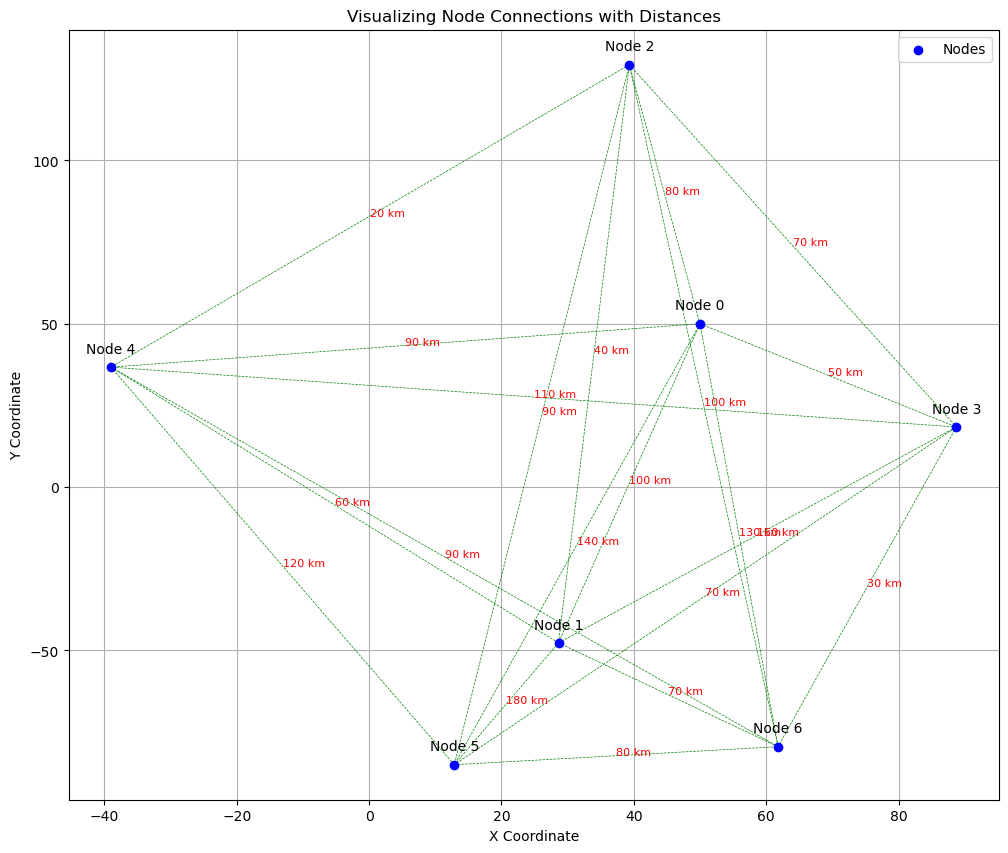

In [7]:
#distance plotting
cleaned_distance_matrix = distance_matrix.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
num_nodes = cleaned_distance_matrix.shape[0]
nodes, distance_matrix = generate_data(num_nodes, cleaned_distance_matrix)

# Plotting
plt.figure(figsize=(12, 10))
locations = np.array([node['location'] for node in nodes])

# Scatter plot for nodes
plt.scatter(locations[:, 0], locations[:, 1], c='blue', label='Nodes', zorder=5)

# Annotate each node with its ID
for i, loc in enumerate(locations):
    plt.annotate(f'Node {i}', (loc[0], loc[1]), textcoords="offset points", xytext=(0,10), ha='center')

# Draw lines and annotate distances
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        # Draw lines between nodes
        plt.plot([locations[i][0], locations[j][0]], [locations[i][1], locations[j][1]], 'g--', lw=0.5)
        # Annotate lines with distances
        mid_x = (locations[i][0] + locations[j][0]) / 2
        mid_y = (locations[i][1] + locations[j][1]) / 2
        plt.text(mid_x, mid_y, f"{distance_matrix[i, j]} km", color='red', fontsize=8)

plt.title('Visualizing Node Connections with Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
def plot_routes_from_info(nodes, routes_info):
    plt.figure(figsize=(12, 10))

    # Plot nodes
    for node in nodes:
        plt.scatter(node['location'][0], node['location'][1], color='blue')
        plt.text(node['location'][0], node['location'][1], f"Node {node['id']}", fontsize=9, ha='right')

    # Draw routes and annotate additional information
    for vehicle_id, info in routes_info.items():
        route = info['route']
        path = [nodes[node_id]['location'] for node_id in route]
        x_coords, y_coords = zip(*path)

        # Draw the route with line and markers
        plt.plot(x_coords, y_coords, marker='o', label=f"Vehicle {vehicle_id}: {info['total_distance']} KM, Delivery {info['total_delivery_kWh']} kWh, Pickup {info['total_pickup_kWh']} kWh, cost {info['total_cost']:.2f} NOK, return: {info['finish_time']:.2f}")

        # Annotate the start and the end of the route
        plt.text(path[0][0], path[0][1], 'Start', fontsize=12, color='green')
        plt.text(path[-1][0], path[-1][1], 'End', fontsize=12, color='red')

        # Annotate skipped nodes if any
        if info['skipped_nodes']:
            for node_id in info['skipped_nodes']:
                node_location = nodes[node_id]['location']
                plt.scatter(node_location[0], node_location[1], color='red')
                plt.text(node_location[0], node_location[1], 'Skipped', color='red', fontsize=12)

    plt.title('Vehicle Routing Visualization')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def animate_routes(nodes, routes_info):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot all nodes
    for node in nodes:
        ax.scatter(node['location'][0], node['location'][1], color='blue')
        ax.text(node['location'][0], node['location'][1], f"Node {node['id']}", fontsize=9, ha='right')

    lines = {vehicle_id: ax.plot([], [], label=f"Vehicle {vehicle_id}", marker='o')[0] for vehicle_id in routes_info}
    points = {vehicle_id: ax.plot([], [], 'ro')[0] for vehicle_id in routes_info}

    def init():
        for line in lines.values():
            line.set_data([], [])
        for point in points.values():
            point.set_data([], [])
        return list(lines.values()) + list(points.values())

    def update(frame):
        for vehicle_id, line in lines.items():
            route = routes_info[vehicle_id]['route']
            x_coords, y_coords = zip(*[nodes[node_id]['location'] for node_id in route[:frame + 1]])
            line.set_data(x_coords, y_coords)
    
        for vehicle_id, point in points.items():
            if frame < len(routes_info[vehicle_id]['route']):
                node_id = routes_info[vehicle_id]['route'][frame]
                x, y = nodes[node_id]['location']  # Explicitly unpack here to avoid confusion
                point.set_data([x], [y])  # Pass x and y as lists to ensure they are sequences
        return list(lines.values()) + list(points.values())

    frames = max(len(info['route']) for info in routes_info.values())
    ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, repeat=True)

    plt.legend()
    plt.title('Animated Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    # Save the animation as a GIF instead of embedding as HTML5 video
    ani.save('Scenerio3.gif', writer=PillowWriter(fps=2))
    
    # Convert the animation to HTML5 video and display it within the notebook
    return HTML(ani.to_html5_video())

Cluster 1: Nodes [1, 2, 4, 5, 6]
Cluster 0: Nodes [3]
Attempting to assign Cluster 1 with total demand: 550
Attempting to assign Cluster 0 with total demand: 130
Vehicle Assignments: {1: [(1, 1), (1, 2), (1, 4)], 2: [(1, 5)], 3: [(1, 6)], 4: [(0, 3)], 5: [], 6: []}
Starting route from depot at location 0 at time 8.00
Skipped node 2 due to timing constraints or SOC% 94.08333333333333
Skipped node 4 due to timing constraints or SOC% 29.0
Arrived at node 1 at time 10.17, SOC: 18.916666666666668%, vehicle speed: 60
depot location: 1
Leaving nodes for depot at 10.666666666666666
Starting route from depot at location 0 at time 8.00
Arrived at node 5 at time 10.83, SOC: 18.583333333333332%, vehicle speed: 60
depot location: 5
Leaving nodes for depot at 11.333333333333334
Starting route from depot at location 0 at time 8.00
Arrived at node 6 at time 11.10, SOC: 6.45%, vehicle speed: 50
depot location: 6
Leaving nodes for depot at 11.6
Starting route from depot at location 0 at time 8.00
Arrive

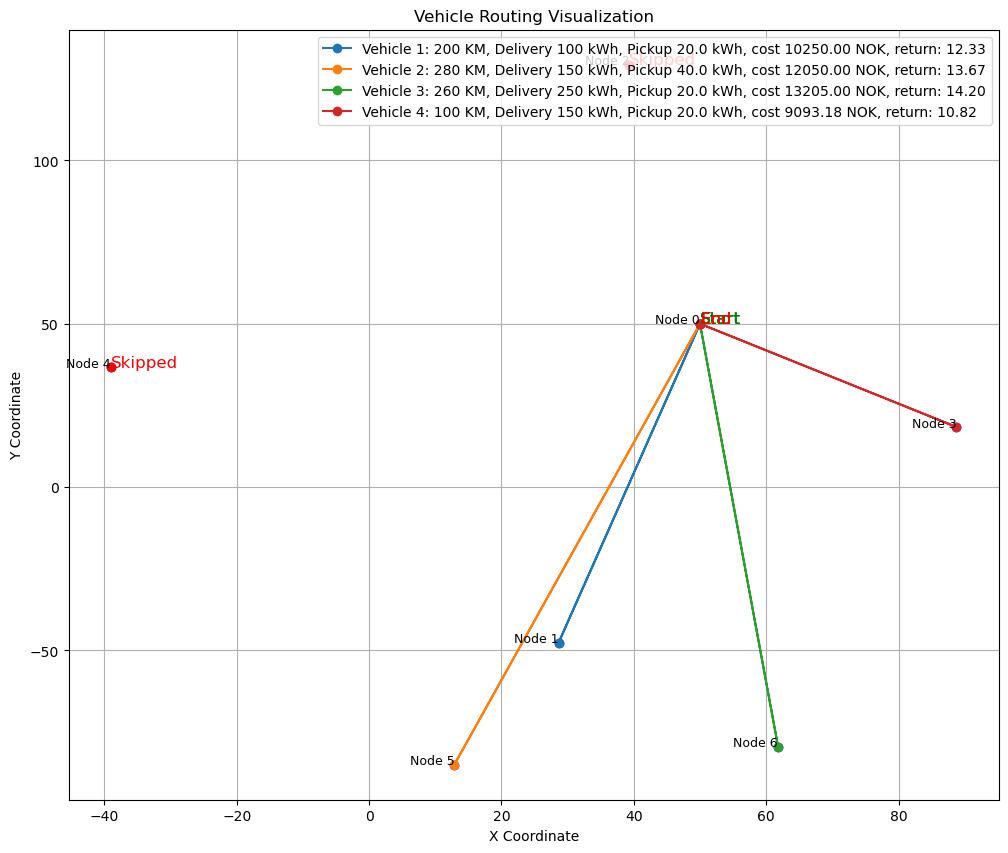

In [10]:
def display_routing_results(routes):
    if not routes:
        print("No routing information available.")
        return

    print("Routing Results:")
    for vehicle_id, info in routes.items():
        print(f"\nVehicle {vehicle_id} Route:")
        print("  Route Path:", ' -> '.join(map(str, info['route'])))
        print(f"  Total Distance Traveled: {info['total_distance']} KM")
        print(f"  Finish Time: {info['finish_time']} hours")
        print(f"  Total Delivery kWh: {info['total_delivery_kWh']}")
        print(f"  Total Pickup kWh: {info['total_pickup_kWh']}")
       
        if 'skipped_nodes' in info and info['skipped_nodes']:
            print("  Skipped Nodes:")
            for node_id in info['skipped_nodes']:
                node = next((node for node in nodes if node['id'] == node_id), None)
                if node:
                    print(f"    Node ID: {node_id}, Demand: {node['demand_kWh']}kWh, Time Window: {node['time_window']}")
                else:
                    print(f"    Node ID: {node_id} details not available.")
        else:
            print("  No nodes were skipped.")
    # print("  Skipped Nodes:")
    # print(f"    Node ID: {node_id}, Demand: {node['demand_kWh']}kWh, Time Window: {node['time_window']}")

clusters= cluster_nodes_by_distance_from_depot(distance_matrix, max_radius)
# Perform the main routing to get the routes information
routes_info = main_routing(vehicles, nodes, distance_matrix, clusters)
# Now display the results
display_routing_results(routes_info)
end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Calculate elapsed time

print(f"Computational Time: {elapsed_time:.2f} seconds")

plot_routes_from_info(nodes, routes_info)

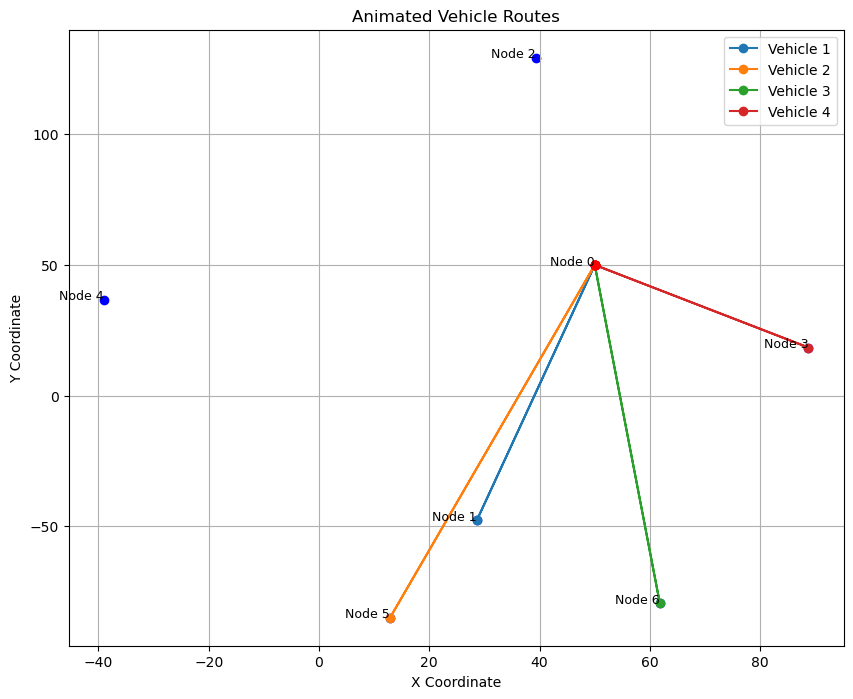

In [11]:
display(animate_routes(nodes, routes_info))